In [8]:
# Cell 1: Imports and Styling

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# set up nice plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [9]:
# Cell 2: Define Paths & Load Metadata CSVs

BASE_DIR    = "/kaggle/input/chest-xrays-indiana-university"
PROJ_CSV    = os.path.join(BASE_DIR, "indiana_projections.csv")
REPORT_CSV  = os.path.join(BASE_DIR, "indiana_reports.csv")
IMAGE_DIR   = os.path.join(BASE_DIR, "images", "images_normalized")

# Load into DataFrames
projections = pd.read_csv(PROJ_CSV)
reports     = pd.read_csv(REPORT_CSV)

# Quick sanity check
print("Projections columns:", projections.columns.tolist())
print("Reports     columns:", reports.columns.tolist())

Projections columns: ['uid', 'filename', 'projection']
Reports     columns: ['uid', 'MeSH', 'Problems', 'image', 'indication', 'comparison', 'findings', 'impression']


In [10]:
# Cell 3: Merge Metadata & Build Filepaths

# Join on the shared 'uid' column
meta = projections.merge(reports, on="uid", how="left")

# Construct full image paths
meta['filepath'] = meta['filename'].apply(lambda fn: os.path.join(IMAGE_DIR, fn))

# Filter out any entries whose image file is missing
meta = meta[meta['filepath'].map(os.path.exists)].reset_index(drop=True)
meta.to_csv('meta.csv', index=False)

print(f"Total images available: {len(meta)}")
meta.head()

Total images available: 7466


,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression,filepath
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,/kaggle/input/chest-xrays-indiana-university/i...
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,/kaggle/input/chest-xrays-indiana-university/i...
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,/kaggle/input/chest-xrays-indiana-university/i...
3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,/kaggle/input/chest-xrays-indiana-university/i...
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p...",/kaggle/input/chest-xrays-indiana-university/i...


Total cleaned unique classes: 118
{'pulmonary fibrosis', 'consolidation', 'bronchiolitis', 'atherosclerosis', 'bronchiectasis', 'catheters, indwelling', 'hernia, diaphragmatic', 'bone and bones', 'cavitation', 'medical device', 'heart', 'thoracic vertebrae', 'nipple shadow', 'hemothorax', 'cysts', 'arthritis', 'fibrosis', 'osteoporosis', 'hemopneumothorax', 'mass', 'pleura', 'cardiac shadow', 'normal', 'osteophyte', 'colonic interposition', 'surgical instruments', 'pleural effusion', 'aorta', 'pneumonia', 'granuloma', 'nodule', 'costophrenic angle', 'lucency', 'hernia, hiatal', 'pulmonary edema', 'opacity', 'adipose tissue', 'blister', 'lung diseases, interstitial', 'spinal fusion', 'tuberculosis', 'funnel chest', 'pulmonary artery', 'hydropneumothorax', 'pulmonary congestion', 'pneumothorax', 'cervical vertebrae', 'sclerosis', 'thickening', 'spondylosis', 'cardiomegaly', 'infiltrate', 'pericardial effusion', 'trachea', 'bronchitis', 'abdomen', 'density', 'heart failure', 'aortic aneur

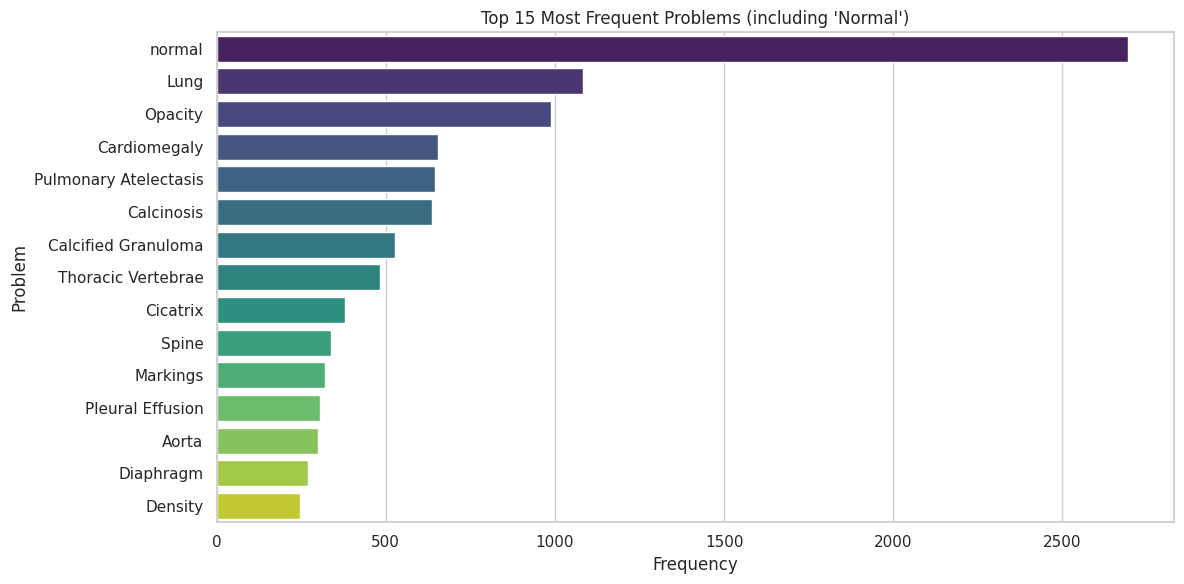

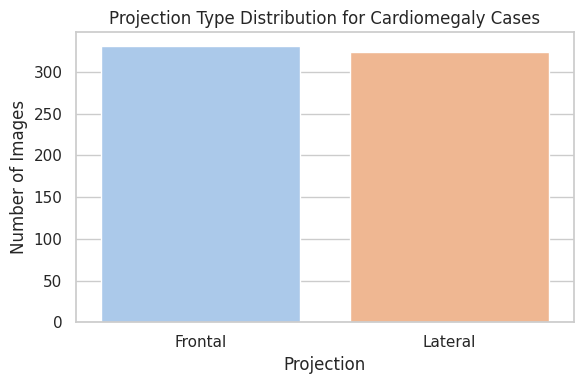

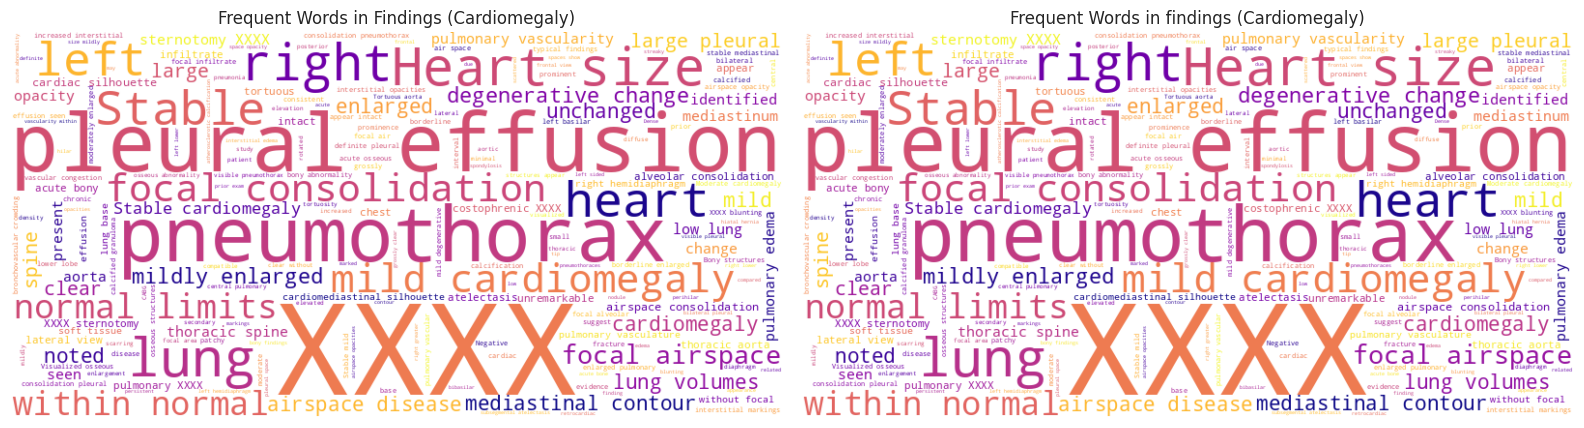

In [11]:
from collections import Counter
from wordcloud import WordCloud

# ========== Analyze the distribution of diseases ==========
# Split the "Problems" column by ';' and flatten the list
problems_split = meta['Problems'].dropna().str.split(';')
problems_flat = [item.strip() for sublist in problems_split for item in sublist]
normalized_classes = set(p.strip().lower().replace("  ", " ") for p in problems_flat)
print(f"Total cleaned unique classes: {len(normalized_classes)}")
print(normalized_classes)

# Count frequency of each problem (including 'Normal')
problem_counts = Counter(problems_flat)
top_problems = problem_counts.most_common(15)

# Create a DataFrame for plotting
problem_df = pd.DataFrame(top_problems, columns=['Problem', 'Count'])

# Plot top 15 most frequent problems
plt.figure(figsize=(12, 6))
sns.barplot(data=problem_df, x='Count', y='Problem', palette="viridis")
plt.title("Top 15 Most Frequent Problems (including 'Normal')")
plt.xlabel("Frequency")
plt.ylabel("Problem")
plt.tight_layout()
plt.show()

# ========== Analyze projection type for Cardiomegaly ==========
# Filter rows containing 'Cardiomegaly'
cardio_df = meta[meta['Problems'].str.contains("Cardiomegaly", case=False, na=False)]

# Count projection types
projection_counts = cardio_df['projection'].value_counts()

# Create a DataFrame for plotting
projection_df = projection_counts.reset_index()
projection_df.columns = ['Projection', 'Count']

# Plot projection distribution
plt.figure(figsize=(6, 4))
sns.barplot(data=projection_df, x='Projection', y='Count', palette="pastel")
plt.title("Projection Type Distribution for Cardiomegaly Cases")
plt.xlabel("Projection")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# ========== Generate WordClouds for Findings and findings ==========
# Combine text for Cardiomegaly cases
text_findings = " ".join(cardio_df['findings'].dropna().astype(str))
text_findings = " ".join(cardio_df['findings'].dropna().astype(str))

# Generate word clouds
wordcloud_findings = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_findings)
wordcloud_findings = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(text_findings)

# Plot word clouds side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_findings, interpolation='bilinear')
plt.axis('off')
plt.title("Frequent Words in Findings (Cardiomegaly)")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_findings, interpolation='bilinear')
plt.axis('off')
plt.title("Frequent Words in findings (Cardiomegaly)")

plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

# Drop rows where 'findings' is NaN
meta_cleaned = meta[meta['findings'].notna() & (meta['findings'].str.strip() != '')]

# Save to a CSV file
meta_cleaned.to_csv('meta_cleaned.csv', index=False)

print("File 'meta_cleaned.csv' has been saved successfully.")

File 'meta_cleaned.csv' has been saved successfully.


In [13]:
meta_cleaned.head

<bound method NDFrame.head of        uid                   filename projection  \
0        1     1_IM-0001-4001.dcm.png    Frontal   
1        1     1_IM-0001-3001.dcm.png    Lateral   
2        2     2_IM-0652-1001.dcm.png    Frontal   
3        2     2_IM-0652-2001.dcm.png    Lateral   
6        4     4_IM-2050-1001.dcm.png    Frontal   
...    ...                        ...        ...   
7457  3995  3995_IM-2046-2001.dcm.png    Lateral   
7458  3996  3996_IM-2047-1001.dcm.png    Frontal   
7459  3996  3996_IM-2047-3001.dcm.png    Lateral   
7460  3997  3997_IM-2048-1001.dcm.png    Frontal   
7461  3997  3997_IM-2048-1002.dcm.png    Lateral   

                                                   MeSH  \
0                                                normal   
1                                                normal   
2     Cardiomegaly/borderline;Pulmonary Artery/enlarged   
3     Cardiomegaly/borderline;Pulmonary Artery/enlarged   
6     Pulmonary Disease, Chronic Obstructive;Bullo

In [14]:
# Cell 6: Image Size Distribution (Height, Width)

# PIL .size returns (width, height), so reverse
dims = meta_cleaned['filepath'].apply(lambda p: Image.open(p).size[::-1])
dims_df = pd.DataFrame(dims.tolist(), columns=['height','width'])

# Summary statistics
dims_df.describe()

,height,width
count,6469.000000,6469.000000
mean,2221.852373,2156.965837
std,219.149178,189.587657
min,1760.000000,1529.000000
25%,2048.000000,2048.000000
50%,2048.000000,2048.000000
75%,2496.000000,2184.000000
max,3001.000000,2891.000000


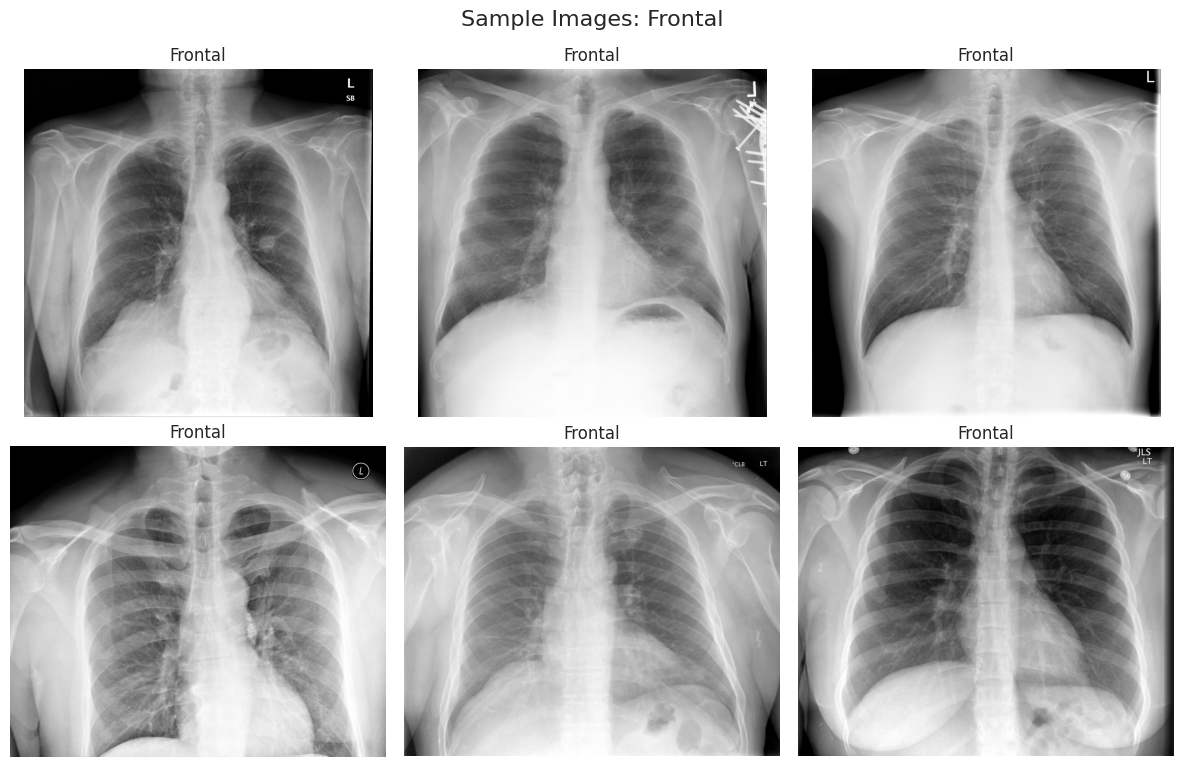

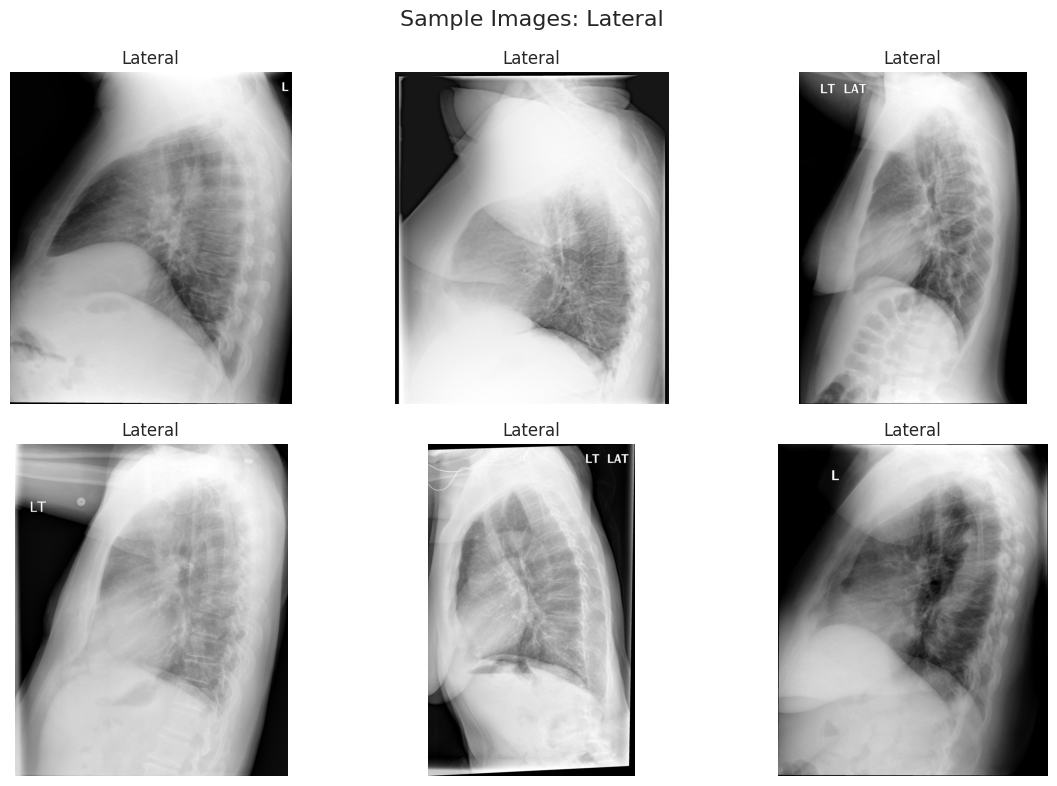

In [15]:
#  Sample Image Grid per Projection

def plot_samples_by_projection(proj, n=6, seed=42):
    subset = meta_cleaned[meta_cleaned.projection == proj]
    paths  = subset.sample(n, random_state=seed)['filepath'].tolist()
    
    cols  = 3
    rows  = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
    axes = axes.flatten()
    
    for ax, p in zip(axes, paths):
        img = Image.open(p)
        ax.imshow(img, cmap="gray")
        ax.set_title(proj)
        ax.axis("off")
    # hide any extra axes
    for ax in axes[len(paths):]:
        ax.axis("off")
        
    plt.suptitle(f"Sample Images: {proj}", fontsize=16)
    plt.tight_layout()
    plt.show()

for proj in meta_cleaned['projection'].unique():
    plot_samples_by_projection(proj, n=6)

In [16]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a word to the vocabulary if it doesn't exist."""
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        """Return the index of the word. Return <unk> index if word not found."""
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        """Return the size of the vocabulary."""
        return len(self.word2idx)
import nltk
from collections import Counter

def build_vocab_from_dataframe(df, text_column, threshold):
    """Build a simple vocabulary wrapper from a DataFrame column (e.g., 'findings')."""
    counter = Counter()

    for i, text in enumerate(df[text_column]):
        if not isinstance(text, str):
            continue
        tokens = nltk.tokenize.word_tokenize(text.lower())
        counter.update(tokens)

        if (i + 1) % 1000 == 0:
            print(f"[{i+1}/{len(df)}] Tokenized the reports.")

    # Filter words by frequency threshold
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create the vocabulary and add special tokens
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add frequent words
    for word in words:
        vocab.add_word(word)

    print(f"Vocabulary size (threshold={threshold}): {len(vocab)}")
    return vocab

In [17]:
# Assuming your DataFrame is named `meta_cleaned` and text column is 'findings'
vocab = build_vocab_from_dataframe(meta_cleaned, text_column='findings', threshold=1)

[1000/6469] Tokenized the reports.
[2000/6469] Tokenized the reports.
[3000/6469] Tokenized the reports.
[4000/6469] Tokenized the reports.
[5000/6469] Tokenized the reports.
[6000/6469] Tokenized the reports.
Vocabulary size (threshold=1): 1753


In [18]:
# Save to file
import pickle
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

# Load later
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [19]:
import argparse
import os
from PIL import Image

def resize_image(image, size):
    return image.resize(size, Image.Resampling.LANCZOS)

def resize_images(image_dir, output_dir, size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        image_path = os.path.join(image_dir, image)
        try:
            with Image.open(image_path) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        except Exception as e:
            print(f"Error processing {image}: {e}")

        if (i + 1) % 100 == 0 or i + 1 == num_images:
            print(f"[{i+1}/{num_images}] Resized images saved to '{output_dir}'.")

def main(args):
    image_dir = args.image_dir
    output_dir = args.output_dir
    image_size = (args.image_size, args.image_size)
    resize_images(image_dir, output_dir, image_size)

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--image_dir', type=str, default='/kaggle/input/chest-xrays-indiana-university/images/images_normalized',
                        help='Directory for input images')
    parser.add_argument('--output_dir', type=str, default='/kaggle/working/resized/',
                        help='Directory to save resized images')
    parser.add_argument('--image_size', type=int, default=224,
                        help='Target size for resized images (square)')
    parser.add_argument('-f', type=str, help='Jupyter passes this automatically; ignore it', default=None)

    args, unknown = parser.parse_known_args()
    main(args)


[100/7470] Resized images saved to '/kaggle/working/resized/'.
[200/7470] Resized images saved to '/kaggle/working/resized/'.
[300/7470] Resized images saved to '/kaggle/working/resized/'.
[400/7470] Resized images saved to '/kaggle/working/resized/'.
[500/7470] Resized images saved to '/kaggle/working/resized/'.
[600/7470] Resized images saved to '/kaggle/working/resized/'.
[700/7470] Resized images saved to '/kaggle/working/resized/'.
[800/7470] Resized images saved to '/kaggle/working/resized/'.
[900/7470] Resized images saved to '/kaggle/working/resized/'.
[1000/7470] Resized images saved to '/kaggle/working/resized/'.
[1100/7470] Resized images saved to '/kaggle/working/resized/'.
[1200/7470] Resized images saved to '/kaggle/working/resized/'.
[1300/7470] Resized images saved to '/kaggle/working/resized/'.
[1400/7470] Resized images saved to '/kaggle/working/resized/'.
[1500/7470] Resized images saved to '/kaggle/working/resized/'.
[1600/7470] Resized images saved to '/kaggle/work

In [20]:
import torch
import torch.utils.data as data
from PIL import Image
import os
import nltk
from torch.utils.data import Dataset

class ChestXrayDatasetFromDF(Dataset):
    def __init__(self, dataframe, image_dir, vocab, transform=None,
                 caption_column='findings', filename_column='filepath'):
        self.df = dataframe
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform
        self.caption_column = caption_column
        self.filename_column = filename_column

    def __getitem__(self, index):
        row = self.df.iloc[index]
        caption_text = str(row[self.caption_column]).lower()
        img_name = img_name = os.path.basename(str(row[self.filename_column]))

        image = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        tokens = nltk.tokenize.word_tokenize(caption_text)
        caption = [self.vocab('<start>')] + [self.vocab(token) for token in tokens] + [self.vocab('<end>')]
        target = torch.Tensor(caption).long()

        return image, target

    def __len__(self):
        return len(self.df)


def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths


def get_loader_from_df(df, image_dir, vocab, transform, batch_size, shuffle, num_workers):
    dataset = ChestXrayDatasetFromDF(df, image_dir, vocab, transform)
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

In [21]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision.models import resnet152, ResNet152_Weights

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        weights = ResNet152_Weights.DEFAULT
        resnet = resnet152(weights=weights)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=50):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generate captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.gru(packed)
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.gru(inputs, states)              # GRU returns only hidden state
            outputs = self.linear(hiddens.squeeze(1))               # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1)                           # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                          # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                            # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                   # (batch_size, max_seq_length)
        return sampled_ids

    
    def beam_search(self, features, vocab, beam_width=3):
        """Generate captions using beam search (using GRU)."""
        k = beam_width
        sequences = [[list(), 0.0, None]]  # [tokens, log_prob, states]
        inputs = features.unsqueeze(1)     # (1, 1, embed_size)
    
        for _ in range(self.max_seg_length):
            all_candidates = []
            for seq, score, states in sequences:
                if len(seq) > 0 and seq[-1] == vocab('<end>'):
                    all_candidates.append((seq, score, states))
                    continue
    
                hiddens, states = self.gru(inputs, states)       # GRU instead of LSTM
                outputs = self.linear(hiddens.squeeze(1))        # (1, vocab_size)
                log_probs = torch.log_softmax(outputs, dim=1)
    
                topk_log_probs, topk_indices = torch.topk(log_probs, k)
    
                for i in range(k):
                    word_id = topk_indices[0][i].item()
                    candidate = (seq + [word_id], score + topk_log_probs[0][i].item(), states)
                    all_candidates.append(candidate)
    
            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = ordered[:k]
    
            best_seq = sequences[0][0]
            next_input = torch.tensor([best_seq[-1]]).to(features.device)
            inputs = self.embed(next_input).unsqueeze(1)
    
            if all(seq[-1] == vocab('<end>') for seq, _, _ in sequences):
                break
    
        final_seq = sequences[0][0]
        caption = []
        for word_id in final_seq:
            word = vocab.idx2word[word_id]
            if word == '<end>':
                break
            if word not in ['<start>', '<pad>']:
                caption.append(word)
        return caption


In [22]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
import pandas as pd
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
import nltk
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import SmoothingFunction
# from data_loader_df import get_loader_from_df 
# from model import EncoderCNN, DecoderRNN  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def calculate_bleu_scores(references, hypotheses):
    smoothie = SmoothingFunction().method4
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    return bleu1, bleu2, bleu3, bleu4

def evaluate_with_bleu(encoder, decoder, data_loader, criterion, vocab):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    total_samples = 0

    references = []
    hypotheses = []

    with torch.no_grad():
        for images, captions, lengths in data_loader:
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

            sampled_ids_batch = decoder.sample(features)
            sampled_ids_batch = sampled_ids_batch.cpu().numpy()

            for i in range(len(sampled_ids_batch)):
                sampled_ids = sampled_ids_batch[i]

                sampled_caption = []
                for word_id in sampled_ids:
                    word = vocab.idx2word[word_id]
                    if word == '<end>':
                        break
                    if word not in ['<start>', '<pad>']:
                        sampled_caption.append(word)
                hypotheses.append(sampled_caption)

                real_caption = []
                for idx in captions[i].cpu().numpy():
                    word = vocab.idx2word[idx]
                    if word == '<end>':
                        break
                    if word not in ['<start>', '<pad>']:
                        real_caption.append(word)
                references.append([real_caption])

    avg_loss = total_loss / total_samples
    encoder.train()
    decoder.train()

    bleu_scores = calculate_bleu_scores(references, hypotheses)
    return avg_loss, bleu_scores

def main(args):
    import matplotlib.pyplot as plt

    if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)

    transform = transforms.Compose([
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    meta = pd.read_csv(args.meta_path)
    train_df, temp_df = train_test_split(meta, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    train_loader = get_loader_from_df(train_df, args.image_dir, vocab, transform,
                                      args.batch_size, shuffle=True, num_workers=args.num_workers)
    val_loader = get_loader_from_df(val_df, args.image_dir, vocab, transform,
                                    args.batch_size, shuffle=False, num_workers=args.num_workers)
    test_loader = get_loader_from_df(test_df, args.image_dir, vocab, transform,
                                     args.batch_size, shuffle=False, num_workers=args.num_workers)

    encoder = EncoderCNN(args.embed_size).to(device)
    decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)

    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=args.learning_rate)

    train_losses = []
    val_losses = []

    # Early stopping setup
    best_val_loss = float('inf')
    patience = args.patience if hasattr(args, 'patience') else 5
    patience_counter = 0

    total_step = len(train_loader)

    for epoch in range(args.num_epochs):
        encoder.train()
        decoder.train()
    
        running_loss = 0.0
        for i, (images, captions, lengths) in enumerate(train_loader):
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)

            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

        if i % args.log_step == 0:
            print(f'Epoch [{epoch+1}/{args.num_epochs}], Step [{i}/{total_step}], '
                  f'Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):5.4f}')

        avg_train_loss = running_loss / total_step
        train_losses.append(avg_train_loss)

        val_loss, val_bleu_scores = evaluate_with_bleu(encoder, decoder, val_loader, criterion, vocab)
        val_losses.append(val_loss)

        print(f'>> Epoch [{epoch+1}] Validation Loss: {val_loss:.4f}, Perplexity: {np.exp(val_loss):5.4f}')
        print(f'>> Validation BLEU-1: {val_bleu_scores[0]:.4f}, BLEU-2: {val_bleu_scores[1]:.4f}, '
              f'BLEU-3: {val_bleu_scores[2]:.4f}, BLEU-4: {val_bleu_scores[3]:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(decoder.state_dict(), os.path.join(args.model_path, 'best_decoder.ckpt'))
            torch.save(encoder.state_dict(), os.path.join(args.model_path, 'best_encoder.ckpt'))
            print(f'>> Saved best model with Val Loss: {best_val_loss:.4f}')
        else:
            patience_counter += 1
            print(f'>> No improvement. Early stopping counter: {patience_counter}/{patience}')
            if patience_counter >= patience:
                print(">> Early stopping triggered.")
                break

    # Load best model before testing
    encoder.load_state_dict(torch.load(os.path.join(args.model_path, 'best_encoder.ckpt')))
    decoder.load_state_dict(torch.load(os.path.join(args.model_path, 'best_decoder.ckpt')))

    test_loss, test_bleu_scores = evaluate_with_bleu(encoder, decoder, test_loader, criterion, vocab)
    print(f'>> Final Test Loss: {test_loss:.4f}, Perplexity: {np.exp(test_loss):5.4f}')
    print(f'>> Final Test BLEU-1: {test_bleu_scores[0]:.4f}, BLEU-2: {test_bleu_scores[1]:.4f}, '
          f'BLEU-3: {test_bleu_scores[2]:.4f}, BLEU-4: {test_bleu_scores[3]:.4f}')

    # 📈 Plot loss curves
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train/Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(args.model_path, 'loss_curve.png'))
    plt.show()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0f3614550b560bcc989cb2db4aee75ad43dcd1c6874ae4bd037c391d58461767
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [24]:
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from sklearn.model_selection import train_test_split
from torchvision import transforms

def evaluate_sample(args, encoder, decoder, vocab, meta, device, get_loader_from_df):
    # Split data
    train_df, temp_df = train_test_split(meta, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    # Transformations
    transform = transforms.Compose([
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])

    # Create test data loader
    test_loader = get_loader_from_df(test_df, args.image_dir, vocab, transform,
                                     args.batch_size, shuffle=False, num_workers=args.num_workers)

    data_iter = iter(test_loader)
    images, captions, lengths = next(data_iter)

    # Take the first image and caption from batch
    image_tensor = images[0].unsqueeze(0).to(device)  # add batch dim
    caption_tensor = captions[0]

    # Decode ground truth caption
    true_caption_words = []
    for idx in caption_tensor.cpu().numpy():
        word = vocab.idx2word[idx]
        if word == '<end>':
            break
        if word not in ['<start>', '<pad>']:
            true_caption_words.append(word)
    true_caption = ' '.join(true_caption_words)

    # Generate caption
    with torch.no_grad():
        features = encoder(image_tensor)
        sampled_ids = decoder.sample(features)  # (1, max_seq_length)
        sampled_ids = sampled_ids[0].cpu().numpy()

    # Decode generated caption
    generated_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        if word == '<end>':
            break
        if word not in ['<start>', '<pad>']:
            generated_caption.append(word)
    generated_caption_text = ' '.join(generated_caption)

    # Undo normalization for display
    inv_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    image_show = inv_normalize(images[0]).clamp(0, 1)
    image_np = image_show.permute(1, 2, 0).cpu().numpy()

    plt.imshow(image_np)
    plt.axis('off')
    plt.title("Generated Caption vs Ground Truth")
    plt.show()

    print(f"🔷 Ground Truth (findings):\n{true_caption}\n")
    print(f"🟢 Generated Caption (Sampled):\n{generated_caption_text}\n")

    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_caption, generated_caption_text)

    print("📊 ROUGE scores:")
    for key in scores:
        print(f"{key}: precision={scores[key].precision:.4f}, recall={scores[key].recall:.4f}, fmeasure={scores[key].fmeasure:.4f}")

    return true_caption, generated_caption_text, scores


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 83.5MB/s] 


Epoch [1/200], Step [80/81], Loss: 4.3172, Perplexity: 74.9756
>> Epoch [1] Validation Loss: 4.2505, Perplexity: 70.1382
>> Validation BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
>> Saved best model with Val Loss: 4.2505
Epoch [2/200], Step [80/81], Loss: 3.4877, Perplexity: 32.7101
>> Epoch [2] Validation Loss: 3.4426, Perplexity: 31.2671
>> Validation BLEU-1: 0.0002, BLEU-2: 0.0001, BLEU-3: 0.0001, BLEU-4: 0.0001
>> Saved best model with Val Loss: 3.4426
Epoch [3/200], Step [80/81], Loss: 2.9974, Perplexity: 20.0325
>> Epoch [3] Validation Loss: 2.9245, Perplexity: 18.6242
>> Validation BLEU-1: 0.0076, BLEU-2: 0.0049, BLEU-3: 0.0035, BLEU-4: 0.0026
>> Saved best model with Val Loss: 2.9245
Epoch [4/200], Step [80/81], Loss: 2.6590, Perplexity: 14.2813
>> Epoch [4] Validation Loss: 2.6168, Perplexity: 13.6917
>> Validation BLEU-1: 0.2924, BLEU-2: 0.1756, BLEU-3: 0.1175, BLEU-4: 0.0795
>> Saved best model with Val Loss: 2.6168
Epoch [5/200], Step [80/81], Loss: 2.262

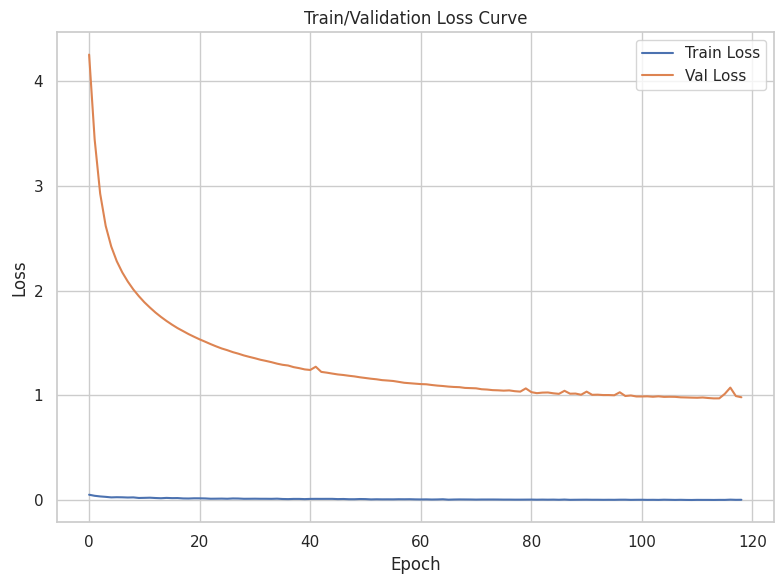

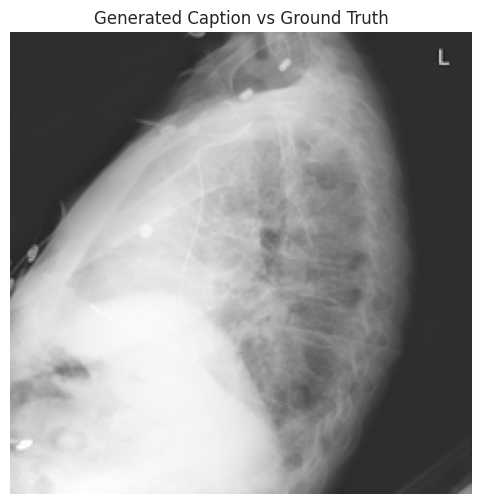

🔷 Ground Truth (findings):
there is a left-sided biventricular pacemaker . leads overlie the right ventricle and a lateral cardiac vein . the leads appear intact . the cardiac silhouette is mildly enlarged . there are mild diffuse bilateral interstitial opacities , xxxx pulmonary edema . there are xxxx opacities overlying the left lung base on the frontal view . no large pleural effusion is seen on the lateral view . no pneumothorax is identified .

🟢 Generated Caption (Sampled):
there is a moderate sized right pleural effusion . severe slightly smaller than is compared to xxxx . there is a small left pleural effusion . this is unchanged as compared to the prior study . there is a right chest wall venous xxxx xxxx which appears accessed .

📊 ROUGE scores:
rouge1: precision=0.3864, recall=0.2656, fmeasure=0.3148
rouge2: precision=0.0698, recall=0.0476, fmeasure=0.0566
rougeL: precision=0.2955, recall=0.2031, fmeasure=0.2407


In [25]:
# import matplotlib.pyplot as plt
# import torchvision.transforms as transforms
# from PIL import Image
# import torch
# import numpy as np
# from rouge_score import rouge_scorer

model_dir = '/kaggle/working/models/'

# # for filename in os.listdir(model_dir):
# #     file_path = os.path.join(model_dir, filename)
# #     if os.path.isfile(file_path):
# #         os.remove(file_path)
# #         print(f"Deleted {file_path}")

# Arguments
class Args:
    model_path = 'models/'
    crop_size = 224
    vocab_path = '/kaggle/working/vocab.pkl'
    meta_path = '/kaggle/working/meta_cleaned.csv'
    image_dir = '/kaggle/working/resized'
    log_step = 20
    embed_size = 256
    hidden_size = 512
    num_layers = 1
    num_epochs = 200
    batch_size = 64
    num_workers = 4
    learning_rate = 1e-4

args = Args()
main(args)

vocab_size = len(vocab)

encoder = EncoderCNN(args.embed_size).to(device)
decoder = DecoderRNN(args.embed_size, args.hidden_size, vocab_size, args.num_layers).to(device)

encoder.load_state_dict(torch.load(f'{args.model_path}/best_encoder.ckpt', map_location=device))
decoder.load_state_dict(torch.load(f'{args.model_path}/best_decoder.ckpt', map_location=device))

encoder.eval()
decoder.eval()


import os
true_caption, generated_caption, rouge_scores = evaluate_sample(args, encoder, decoder, vocab, meta, device, get_loader_from_df)